In [1]:
import pandas as pd
import re
from unidecode import unidecode
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from textblob import TextBlob
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from gensim import corpora
from gensim.models import LdaModel
from nltk.util import ngrams
from collections import Counter
import seaborn as sns
import numpy as np 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from gensim.models import TfidfModel

In [2]:
df = pd.read_json("cleaned_data.json", lines=True)

# Sentimental Analysis

In [3]:
# Text Blob
def calculate_sentiment(tokens):
    text = ' '.join(tokens)  # Convert tokens back to a single string
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    subjectivity = blob.sentiment.subjectivity
    
    if polarity > 0:
        sentiment = "positive"
    elif polarity < 0:
        sentiment = "negative"
    else:
        sentiment = "neutral"
    return polarity, subjectivity,sentiment

# Apply the sentiment calculation function to each row
df[['textblob_polarity', 'textblob_subjectivity','textblob_sentiment']] = df['lemmatized_tokens'].apply(calculate_sentiment).apply(pd.Series)


In [4]:
# VADER 
analyzer = SentimentIntensityAnalyzer()

# Create a function to calculate sentiment scores
def get_sentiment_scores(tokens):
    # Combine the lemmatized tokens back into a text
    text = ' '.join(tokens)
    
    # Calculate sentiment scores
    sentiment = analyzer.polarity_scores(text)
    compound_score = sentiment['compound']
    
    if compound_score >= 0.05:
        sentiment_label = 'Positive'
    elif compound_score <= -0.05:
        sentiment_label = 'Negative'
    else:
        sentiment_label = 'Neutral'
    
    return compound_score, sentiment_label

# Calculate sentiment scores for each row and store them in new columns
df[['vader_compound_score', 'vader_sentiment']] = df['lemmatized_tokens'].apply(get_sentiment_scores).apply(pd.Series)


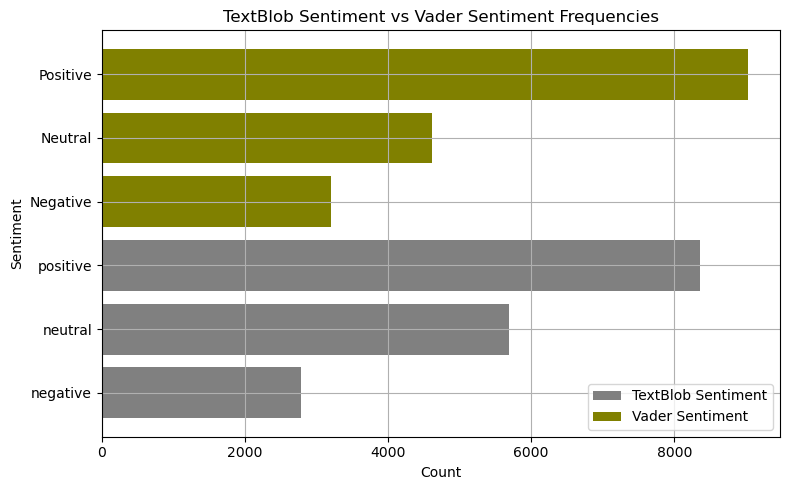

In [5]:
sentiment_counts = df.groupby('textblob_sentiment').size()
vader_sentiment_counts = df.groupby('vader_sentiment').size()

# Create a single graph for sentiment and Vader sentiment vs frequency
plt.figure(figsize=(8, 5))

# Plot sentiment counts
plt.barh(sentiment_counts.index, sentiment_counts.values, color='grey', label='TextBlob Sentiment')

# Plot Vader sentiment counts
plt.barh(vader_sentiment_counts.index, vader_sentiment_counts.values, color='olive', label='Vader Sentiment')

plt.xlabel('Count')
plt.ylabel('Sentiment')
plt.title('TextBlob Sentiment vs Vader Sentiment Frequencies')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

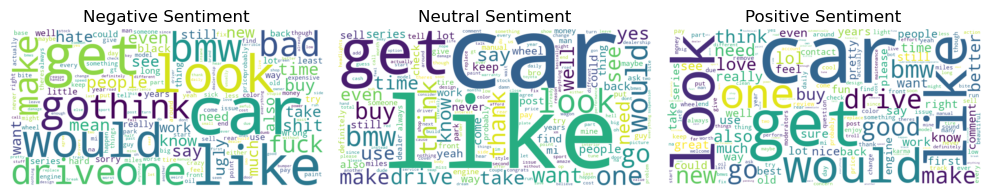

In [6]:
# Group data by sentiment and merge tokens
grouped = df.groupby('textblob_sentiment')['lemmatized_tokens'].apply(lambda x: [token for sublist in x for token in sublist])

# Count word frequencies in each sentiment group
word_counts = {sentiment: Counter(tokens) for sentiment, tokens in grouped.items()}

# Set up subplots
fig, axes = plt.subplots(1, 3, figsize=(10, 10))

# Create word clouds for each sentiment group and display in subplots
for i, (sentiment, counts) in enumerate(word_counts.items()):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(counts)
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f'{sentiment.capitalize()} Sentiment')
    axes[i].axis('off')

# Adjust layout spacing
plt.tight_layout()
plt.show()

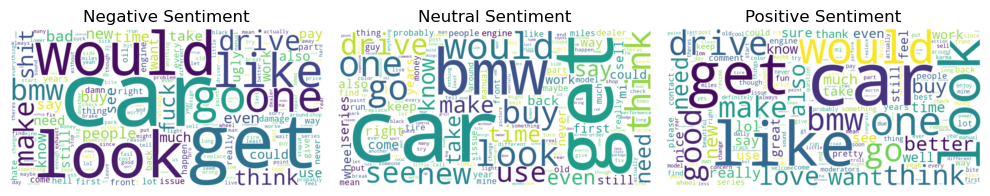

In [7]:
# Group data by sentiment and merge tokens
grouped = df.groupby('vader_sentiment')['lemmatized_tokens'].apply(lambda x: [token for sublist in x for token in sublist])

# Count word frequencies in each sentiment group
word_counts = {sentiment: Counter(tokens) for sentiment, tokens in grouped.items()}

# Set up subplots
fig, axes = plt.subplots(1, 3, figsize=(10, 10))

# Create word clouds for each sentiment group and display in subplots
for i, (sentiment, counts) in enumerate(word_counts.items()):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(counts)
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f'{sentiment.capitalize()} Sentiment')
    axes[i].axis('off')

# Adjust layout spacing
plt.tight_layout()
plt.show()

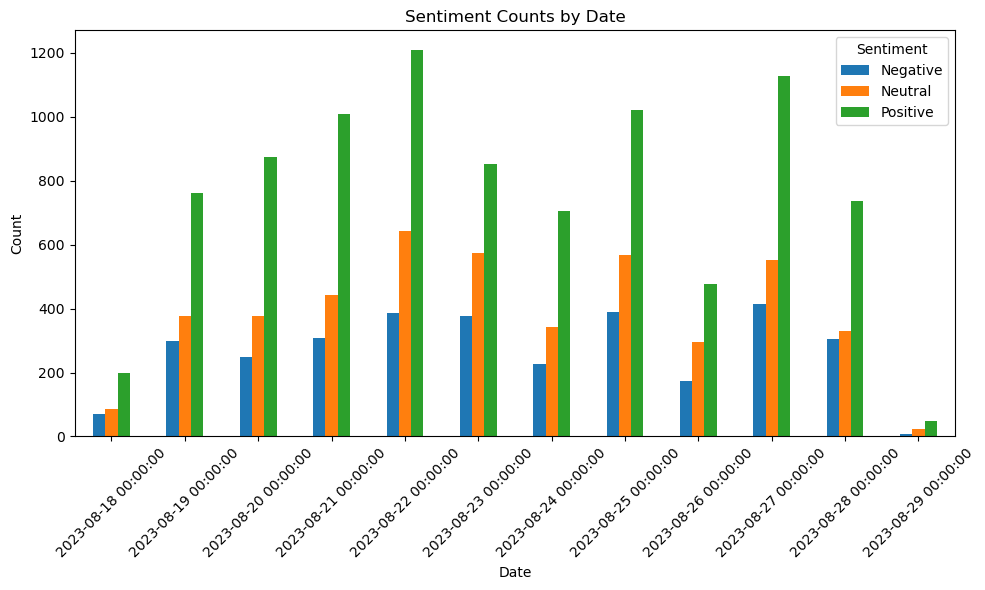

In [8]:
grouped = df.groupby(['date', 'vader_sentiment']).size().unstack(fill_value=0)


grouped.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Sentiment Counts by Date')
plt.legend(title='Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
# Sorting DataFrame by 'vader_compound_score'
df_sorted = df.sort_values(by='vader_compound_score', ascending=False)

# Retrieving the top 5 and bottom 5 comments with their corresponding titles, bodies, and scores
top_comments = df_sorted.nlargest(5, 'vader_compound_score')[['post_title', 'comment', 'vader_compound_score']]
bottom_comments = df_sorted.nsmallest(5, 'vader_compound_score')[['post_title', 'comment', 'vader_compound_score']]

# Printing the results
print("Top 5 Comments with Highest Compound Scores:")
print(top_comments)

print("\nBottom 5 Comments with Lowest Compound Scores:")
print(bottom_comments)

Top 5 Comments with Highest Compound Scores:
                                              post_title  \
13725  New To This Topic: I just Bought a 2024 BMW M4...   
6979           Drove a G31 5 series - quite disappointed   
14056  What's the appeal of older / classic BMWs to you?   
4820                            How did you get an M car   
4560            Got this email from BMW yesterday, wth??   

                                                 comment  vader_compound_score  
13725  Ok, your question is a loaded question.  Reall...                0.9944  
6979   The newer 5 series cars definitely lack the pr...                0.9940  
14056  Cars were much purer driving experience prior ...                0.9935  
4820   currently 26. spent a couple years building my...                0.9929  
4560   Call not respond to the email, the place where...                0.9924  

Bottom 5 Comments with Lowest Compound Scores:
                                              post_title  \


# Topic modelling

BOW method

In [10]:
dictionary_bow = corpora.Dictionary(df['lemmatized_tokens'])

# Create a corpus (bag of words representation) from the unigrams
corpus = [dictionary_bow.doc2bow(unigram) for unigram in df['lemmatized_tokens']]

# Build the LDA model
lda_model_bow = LdaModel(corpus, num_topics= 4, id2word=dictionary_bow, passes=15)

In [11]:
# Print the topics and their top terms
topics_bow = lda_model_bow.print_topics(num_words=50)
for topic in topics_bow:
    print(topic)

(0, '0.031*"comment" + 0.028*"please" + 0.024*"need" + 0.023*"contact" + 0.022*"moderators" + 0.019*"review" + 0.019*"question" + 0.019*"karma" + 0.018*"post" + 0.016*"remove" + 0.016*"soon" + 0.016*"due" + 0.015*"welcome" + 0.014*"check" + 0.014*"low" + 0.014*"concern" + 0.013*"thank" + 0.013*"account" + 0.013*"perform" + 0.012*"also" + 0.012*"bot" + 0.012*"action" + 0.012*"automatically" + 0.012*"effort" + 0.011*"troll" + 0.011*"subredditmessagecomposeto" + 0.011*"minimum" + 0.011*"bots" + 0.011*"combat" + 0.011*"submission" + 0.010*"subreddit" + 0.010*"technical" + 0.009*"immediate" + 0.009*"assistance" + 0.009*"moderator" + 0.009*"pending" + 0.009*"temporarily" + 0.009*"freely" + 0.005*"yes" + 0.005*"rule" + 0.003*"phone" + 0.003*"message" + 0.003*"ev" + 0.002*"old" + 0.002*"wait" + 0.002*"traffic" + 0.002*"new" + 0.002*"approval" + 0.002*"recommend" + 0.002*"hours"')
(1, '0.032*"car" + 0.020*"look" + 0.018*"get" + 0.017*"like" + 0.010*"one" + 0.009*"drive" + 0.008*"love" + 0.008*"

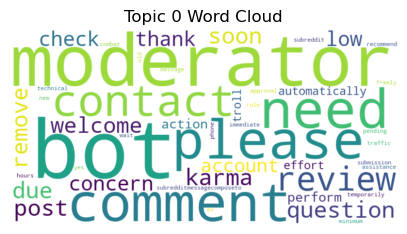

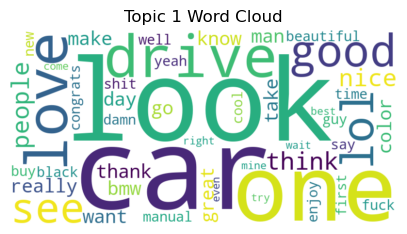

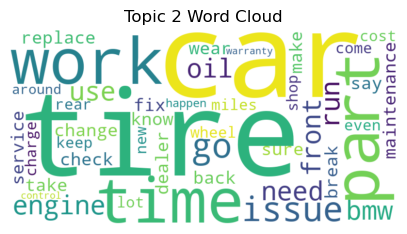

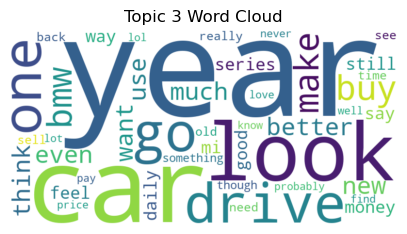

In [12]:
# Initialize an empty list to store the topics
topics__bow_list = []

# Parse the topics and extract terms
for topic_id, terms_line in topics_bow:
    # Extract terms
    terms = re.findall(r'"([^"]+)"', terms_line)
    
    # Append the list of terms to the topics_list
    topics__bow_list.append(terms)


# Create word clouds for each topic
for i, topic in enumerate(topics__bow_list):
    # Convert the list of terms into a space-separated string
    text = " ".join(topic)
    
    # Create a WordCloud object
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    # Display the WordCloud
    plt.figure(figsize=(5, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Topic {i} Word Cloud")
    plt.axis("off")
    plt.show()

TF-IDF method

In [13]:
dictionary_tf = corpora.Dictionary(df['lemmatized_tokens'])

# Create a corpus (bag of words representation) from the unigrams
corpus_bow = [dictionary_tf.doc2bow(unigram) for unigram in df['lemmatized_tokens']]

# Build the TF-IDF model
tfidf_model = TfidfModel(corpus_bow)

# Apply TF-IDF transformation to the bag of words corpus
corpus_tfidf = [tfidf_model[doc] for doc in corpus_bow]

# Build the LDA model using TF-IDF corpus
lda_model_tf = LdaModel(corpus_tfidf, num_topics=4, id2word=dictionary_tf, passes=15)

In [14]:
# Print the topics and their top terms
topics_tf = lda_model_tf.print_topics(num_words=50)
for topic in topics_tf:
    print(topic)

(0, '0.029*"thank" + 0.015*"beautiful" + 0.012*"color" + 0.006*"bro" + 0.006*"camber" + 0.005*"grill" + 0.005*"sweet" + 0.004*"gorgeous" + 0.004*"black" + 0.004*"beauty" + 0.004*"blue" + 0.004*"plate" + 0.003*"toe" + 0.003*"tint" + 0.003*"grille" + 0.003*"true" + 0.003*"clap" + 0.003*"ex" + 0.003*"joke" + 0.003*"lmao" + 0.003*"screen" + 0.003*"green" + 0.003*"nope" + 0.003*"strip" + 0.002*"frame" + 0.002*"favorite" + 0.002*"photo" + 0.002*"love" + 0.002*"lucky" + 0.002*"signal" + 0.002*"paint" + 0.002*"pss" + 0.002*"name" + 0.002*"city" + 0.002*"bike" + 0.002*"steal" + 0.002*"license" + 0.002*"fake" + 0.002*"local" + 0.002*"california" + 0.002*"input" + 0.002*"story" + 0.002*"exactly" + 0.002*"odd" + 0.002*"wtf" + 0.002*"sad" + 0.002*"specs" + 0.002*"white" + 0.001*"nice" + 0.001*"hahaha"')
(1, '0.010*"lol" + 0.009*"like" + 0.009*"look" + 0.008*"awesome" + 0.006*"good" + 0.005*"ok" + 0.005*"damn" + 0.005*"wow" + 0.005*"congratulations" + 0.005*"hell" + 0.004*"ugly" + 0.004*"sub" + 0.00

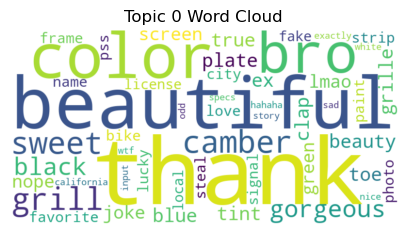

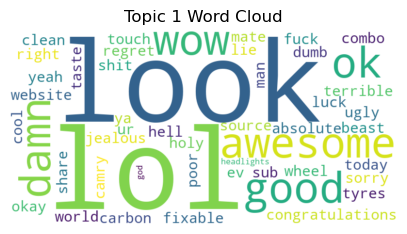

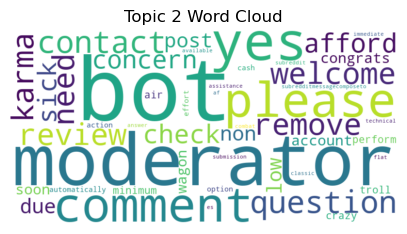

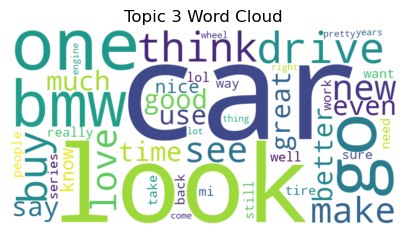

In [15]:
# Initialize an empty list to store the topics
topics_tf_list = []

# Parse the topics and extract terms
for topic_id, terms_line in topics_tf:
    # Extract terms
    terms = re.findall(r'"([^"]+)"', terms_line)
    
    # Append the list of terms to the topics_list
    topics_tf_list.append(terms)


# Create word clouds for each topic
for i, topic in enumerate(topics_tf_list):
    # Convert the list of terms into a space-separated string
    text = " ".join(topic)
    
    # Create a WordCloud object
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    # Display the WordCloud
    plt.figure(figsize=(5, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Topic {i} Word Cloud")
    plt.axis("off")
    plt.show()

Analysis of LDA model which was trained on BOW

Topic-0

In [19]:
# Filter rows based on the presence of specific words in lemmatized_tokens
desired_words = ["comment", "please", "need", "contact", "moderators"]
filtered_rows = df[df['lemmatized_tokens'].apply(lambda tokens: any(word in tokens for word in desired_words))]

# Create a new DataFrame with the filtered rows and selected columns
topic_0_df = filtered_rows[['post_title', 'comment', 'vader_compound_score', 'vader_sentiment']]

In [20]:
# Sorting DataFrame by 'vader_compound_score'
df_sorted = topic_0_df.sort_values(by='vader_compound_score', ascending=False)

# Retrieving the top 5 and bottom 5 comments with their corresponding titles, bodies, and scores
top_comments = df_sorted.nlargest(5, 'vader_compound_score')[['post_title', 'comment', 'vader_compound_score', 'vader_sentiment']]
bottom_comments = df_sorted.nsmallest(5, 'vader_compound_score')[['post_title', 'comment', 'vader_compound_score', 'vader_sentiment']]

# Printing the results
print("Top 5 Comments with Highest Compound Scores:")
print(top_comments)

print("\nBottom 5 Comments with Lowest Compound Scores:")
print(bottom_comments)

Top 5 Comments with Highest Compound Scores:
                                              post_title  \
13725  New To This Topic: I just Bought a 2024 BMW M4...   
11881  Not really close if we are talking about the p...   
7111                F87 M2C or E92 M3 + practical daily?   
10531  Talk me out of buying a '15 M235i over a '23 GR86   
1048                 Why does everyone hate "GT" models?   

                                                 comment  \
13725  Ok, your question is a loaded question.  Reall...   
11881  Drove an f82 m4 and my 340. Here’s my thought....   
7111   I enjoy having two cars (sti and m3) allows me...   
10531  F22 M235i owner here, along with an E46 330i, ...   
1048   I guess I must be weird, because I've had tota...   

       vader_compound_score vader_sentiment  
13725                0.9944        Positive  
11881                0.9892        Positive  
7111                 0.9884        Positive  
10531                0.9883        Positive  
104

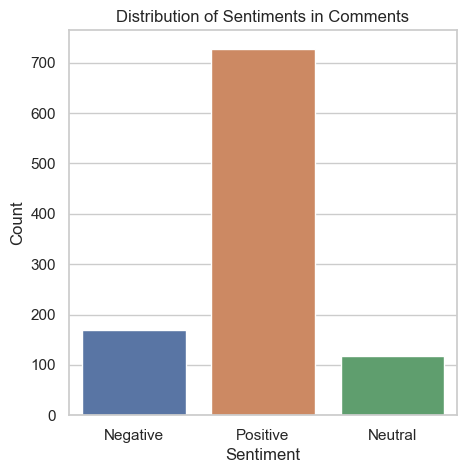

In [21]:
# Create a countplot to visualize sentiment distribution
plt.figure(figsize=(5, 5))
sns.set(style="whitegrid")
sns.countplot(x='vader_sentiment', data=topic_0_df)

# Add labels and title
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiments in Comments')

# Show the plot
plt.show()

Topic-1

In [22]:
# Filter rows based on the presence of specific words in lemmatized_tokens
desired_words = ["car", "look", "drive", "love", "great"]
filtered_rows = df[df['lemmatized_tokens'].apply(lambda tokens: any(word in tokens for word in desired_words))]

# Create a new DataFrame with the filtered rows and selected columns
topic_0_df = filtered_rows[['post_title', 'comment', 'vader_compound_score', 'vader_sentiment']]

In [23]:
# Sorting DataFrame by 'vader_compound_score'
df_sorted = topic_0_df.sort_values(by='vader_compound_score', ascending=False)

# Retrieving the top 5 and bottom 5 comments with their corresponding titles, bodies, and scores
top_comments = df_sorted.nlargest(5, 'vader_compound_score')[['post_title', 'comment', 'vader_compound_score', 'vader_sentiment']]
bottom_comments = df_sorted.nsmallest(5, 'vader_compound_score')[['post_title', 'comment', 'vader_compound_score', 'vader_sentiment']]

# Printing the results
print("Top 5 Comments with Highest Compound Scores:")
print(top_comments)

print("\nBottom 5 Comments with Lowest Compound Scores:")
print(bottom_comments)

Top 5 Comments with Highest Compound Scores:
                                              post_title  \
13725  New To This Topic: I just Bought a 2024 BMW M4...   
6979           Drove a G31 5 series - quite disappointed   
14056  What's the appeal of older / classic BMWs to you?   
4820                            How did you get an M car   
4560            Got this email from BMW yesterday, wth??   

                                                 comment  \
13725  Ok, your question is a loaded question.  Reall...   
6979   The newer 5 series cars definitely lack the pr...   
14056  Cars were much purer driving experience prior ...   
4820   currently 26. spent a couple years building my...   
4560   Call not respond to the email, the place where...   

       vader_compound_score vader_sentiment  
13725                0.9944        Positive  
6979                 0.9940        Positive  
14056                0.9935        Positive  
4820                 0.9929        Positive  
456

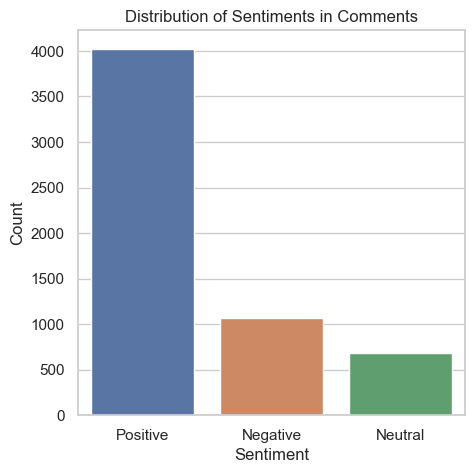

In [24]:
# Create a countplot to visualize sentiment distribution
plt.figure(figsize=(5, 5))
sns.set(style="whitegrid")
sns.countplot(x='vader_sentiment', data=topic_0_df)

# Add labels and title
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiments in Comments')

# Show the plot
plt.show()

Topic-2

In [25]:
# Filter rows based on the presence of specific words in lemmatized_tokens
desired_words = ["tire", "work", "part", "issue", "engine"]
filtered_rows = df[df['lemmatized_tokens'].apply(lambda tokens: any(word in tokens for word in desired_words))]

# Create a new DataFrame with the filtered rows and selected columns
topic_0_df = filtered_rows[['post_title', 'comment', 'vader_compound_score', 'vader_sentiment']]

In [26]:
# Sorting DataFrame by 'vader_compound_score'
df_sorted = topic_0_df.sort_values(by='vader_compound_score', ascending=False)

# Retrieving the top 5 and bottom 5 comments with their corresponding titles, bodies, and scores
top_comments = df_sorted.nlargest(5, 'vader_compound_score')[['post_title', 'comment', 'vader_compound_score', 'vader_sentiment']]
bottom_comments = df_sorted.nsmallest(5, 'vader_compound_score')[['post_title', 'comment', 'vader_compound_score', 'vader_sentiment']]

# Printing the results
print("Top 5 Comments with Highest Compound Scores:")
print(top_comments)

print("\nBottom 5 Comments with Lowest Compound Scores:")
print(bottom_comments)

Top 5 Comments with Highest Compound Scores:
                                              post_title  \
13725  New To This Topic: I just Bought a 2024 BMW M4...   
14056  What's the appeal of older / classic BMWs to you?   
4818                            How did you get an M car   
10633  Talk me out of buying a '15 M235i over a '23 GR86   
11881  Not really close if we are talking about the p...   

                                                 comment  \
13725  Ok, your question is a loaded question.  Reall...   
14056  Cars were much purer driving experience prior ...   
4818   I got a credit card on my 18th birthday. Maxed...   
10633  Dude, if you want a *sports car*, get the GR. ...   
11881  Drove an f82 m4 and my 340. Here’s my thought....   

       vader_compound_score vader_sentiment  
13725                0.9944        Positive  
14056                0.9935        Positive  
4818                 0.9916        Positive  
10633                0.9903        Positive  
118

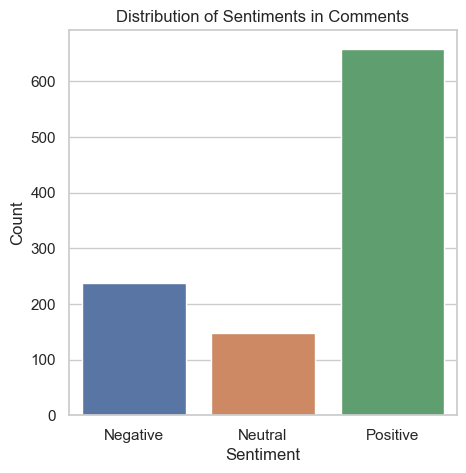

In [27]:
# Create a countplot to visualize sentiment distribution
plt.figure(figsize=(5, 5))
sns.set(style="whitegrid")
sns.countplot(x='vader_sentiment', data=topic_0_df)

# Add labels and title
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiments in Comments')

# Show the plot
plt.show()

Topic-3

In [28]:
# Filter rows based on the presence of specific words in lemmatized_tokens
desired_words = ["better", "sell", "buy", "old", "money"]
filtered_rows = df[df['lemmatized_tokens'].apply(lambda tokens: any(word in tokens for word in desired_words))]

# Create a new DataFrame with the filtered rows and selected columns
topic_0_df = filtered_rows[['post_title', 'comment', 'vader_compound_score', 'vader_sentiment']]

In [29]:
# Sorting DataFrame by 'vader_compound_score'
df_sorted = topic_0_df.sort_values(by='vader_compound_score', ascending=False)

# Retrieving the top 5 and bottom 5 comments with their corresponding titles, bodies, and scores
top_comments = df_sorted.nlargest(5, 'vader_compound_score')[['post_title', 'comment', 'vader_compound_score', 'vader_sentiment']]
bottom_comments = df_sorted.nsmallest(5, 'vader_compound_score')[['post_title', 'comment', 'vader_compound_score', 'vader_sentiment']]

# Printing the results
print("Top 5 Comments with Highest Compound Scores:")
print(top_comments)

print("\nBottom 5 Comments with Lowest Compound Scores:")
print(bottom_comments)

Top 5 Comments with Highest Compound Scores:
                                              post_title  \
13725  New To This Topic: I just Bought a 2024 BMW M4...   
6979           Drove a G31 5 series - quite disappointed   
4820                            How did you get an M car   
4560            Got this email from BMW yesterday, wth??   
4818                            How did you get an M car   

                                                 comment  \
13725  Ok, your question is a loaded question.  Reall...   
6979   The newer 5 series cars definitely lack the pr...   
4820   currently 26. spent a couple years building my...   
4560   Call not respond to the email, the place where...   
4818   I got a credit card on my 18th birthday. Maxed...   

       vader_compound_score vader_sentiment  
13725                0.9944        Positive  
6979                 0.9940        Positive  
4820                 0.9929        Positive  
4560                 0.9924        Positive  
481

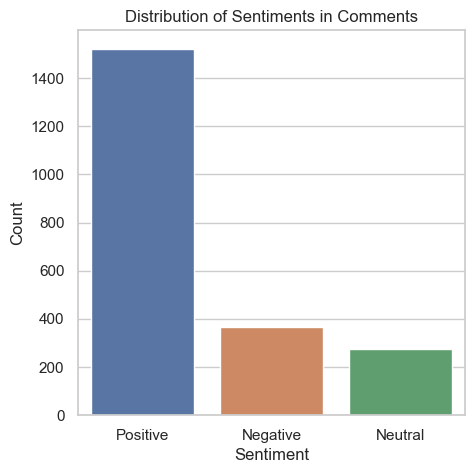

In [31]:
# Create a countplot to visualize sentiment distribution
plt.figure(figsize=(5, 5))
sns.set(style="whitegrid")
sns.countplot(x='vader_sentiment', data=topic_0_df)

# Add labels and title
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiments in Comments')

# Show the plot
plt.show()